# Exploratory Data Analysis for Tetuan City Power Consumption

### import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [2]:
dataset = pd.read_csv('..\..\..\..\Tetuan City power consumption.csv')

### Parse DateTime column, check frequency and consistency
- remove rows where DateTime is missing
- sort dataset using inplace=true to save memory
- calculate most common interval
- Identify and count missing timestamps
  - Time interval is 10 minutes
  - After dropping invalid datetime rows - we here are checking for any missing timestamps row based on most common interval
  - 2023-01-01 00:00  
  - 2023-01-01 00:10  
  - 2023-01-01 00:30   ← 🔥 00:20 is missing!  
  - 2023-01-01 00:40  

In [3]:
# Convert 'DateTime' to datetime type (with error handling)
dataset['DateTime'] = pd.to_datetime(dataset['DateTime'], errors='coerce')

# Drop rows where DateTime conversion failed
dataset.dropna(subset=['DateTime'], inplace=True)

# Sort in-place to save memory
dataset.sort_values('DateTime', inplace=True)

# Set DateTime as index (helps with time-based operations)
dataset.set_index('DateTime', inplace=True)

# Calculate differences between timestamps
dataset['diff'] = dataset.index.to_series().diff()

# Print range
print("Date range:", dataset.index.min(), "to", dataset.index.max())

# Calculate and print most common interval
most_common_interval = dataset['diff'].mode()[0]
print("Most common interval:", most_common_interval)

# Generate full expected time index
expected_index = pd.date_range(
    start=dataset.index.min(),
    end=dataset.index.max(),
    freq=most_common_interval
)

# Identify and count missing timestamps
missing_timestamps = expected_index.difference(dataset.index)
print("Missing timestamps:", len(missing_timestamps))

# Find duplicates
duplicate_count = dataset.index.duplicated().sum()
print(f"Duplicate timestamps found: {duplicate_count}")

Date range: 2017-01-01 00:00:00 to 2017-12-30 23:50:00
Most common interval: 0 days 00:10:00
Missing timestamps: 0
Duplicate timestamps found: 0


In [4]:
print(dataset.columns.tolist())

['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption', 'diff']


### Visualize trends in power consumption across zones

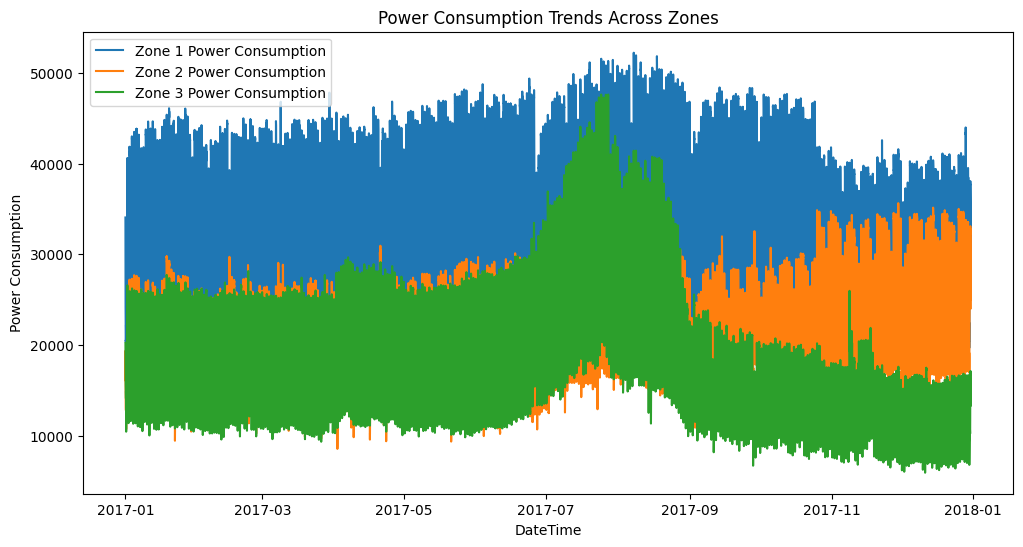

In [5]:
plt.figure(figsize=(12,6))
for zone in ['Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption']:
    plt.plot(dataset.index, dataset[zone], label=zone)

plt.legend()
plt.title('Power Consumption Trends Across Zones')
plt.xlabel('DateTime')
plt.ylabel('Power Consumption')
plt.show()

### Compare with envirnmental features using scatter and line plots

#### Zone 1 Power Consumption vs Environmental Features 

Temperature: min = 3.247, max = 40.01
Zone 1 Power Consumption: min = 13895.6962, max = 52204.39512


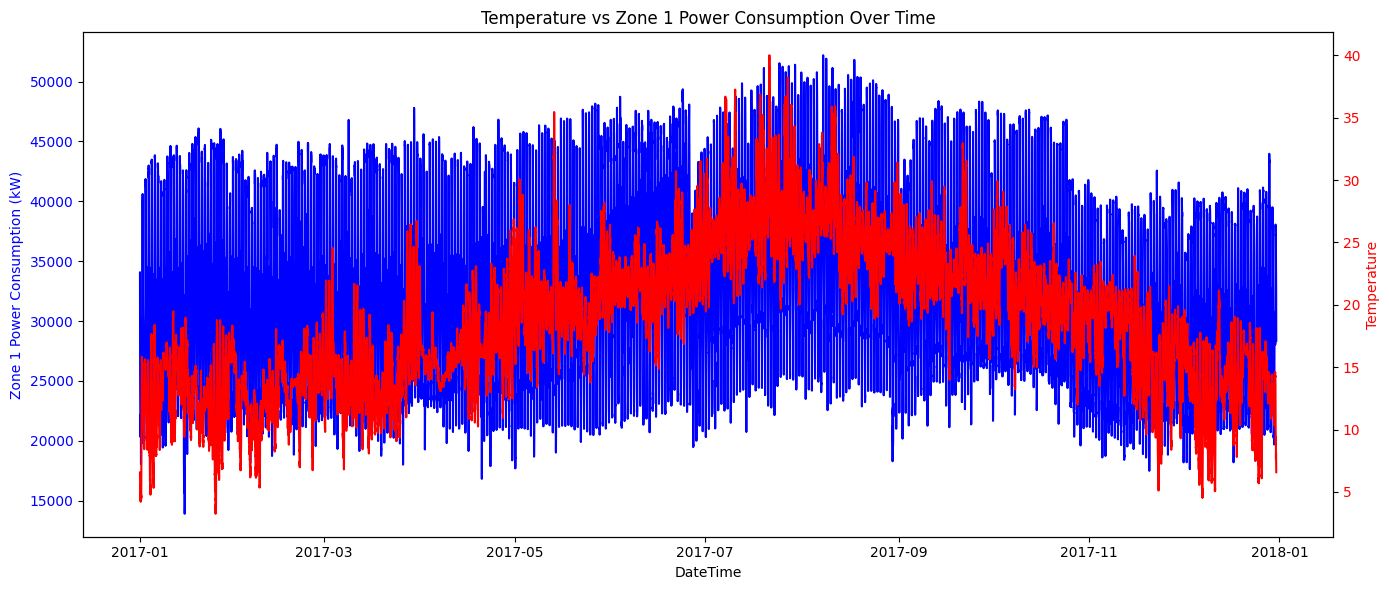

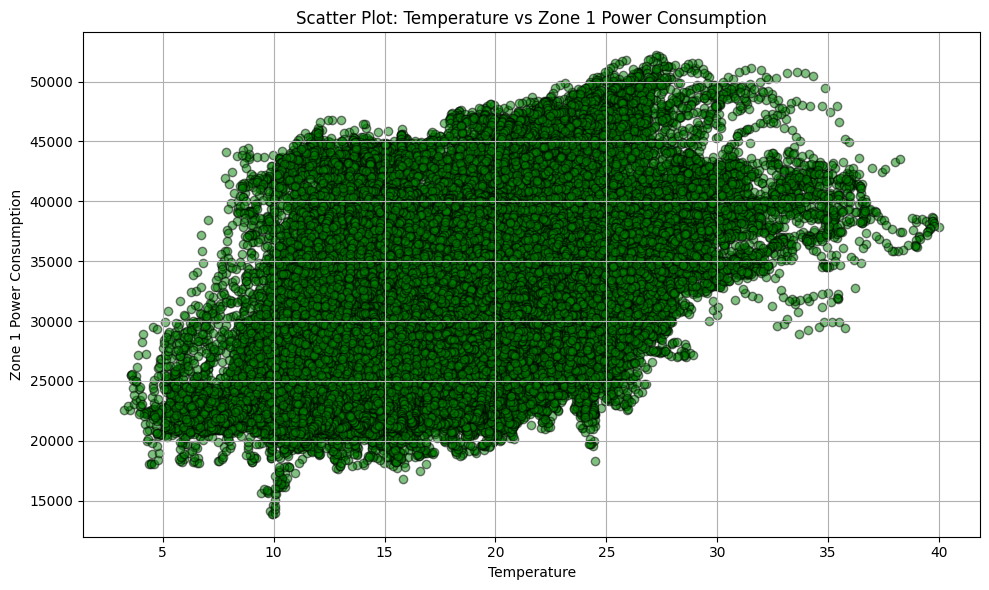

Humidity: min = 11.34, max = 94.8
Zone 1 Power Consumption: min = 13895.6962, max = 52204.39512


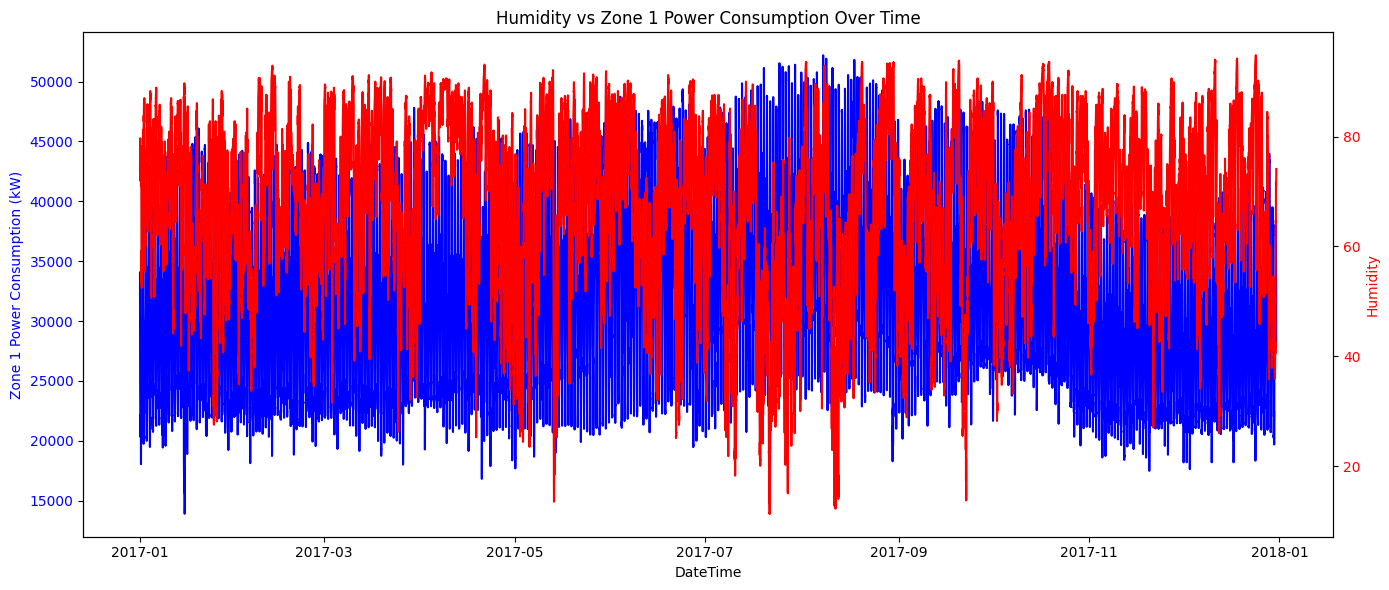

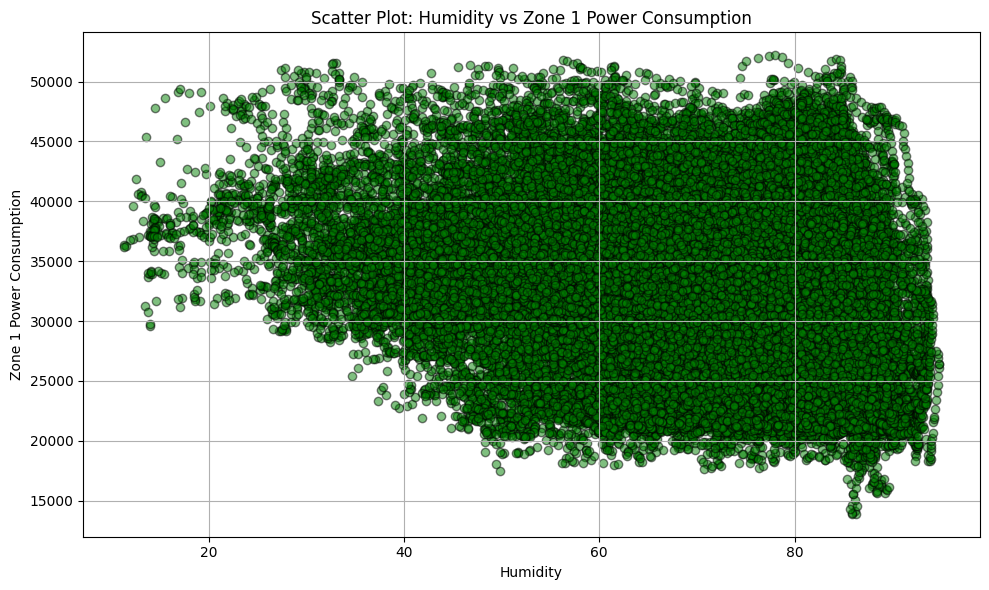

Wind Speed: min = 0.05, max = 6.483
Zone 1 Power Consumption: min = 13895.6962, max = 52204.39512


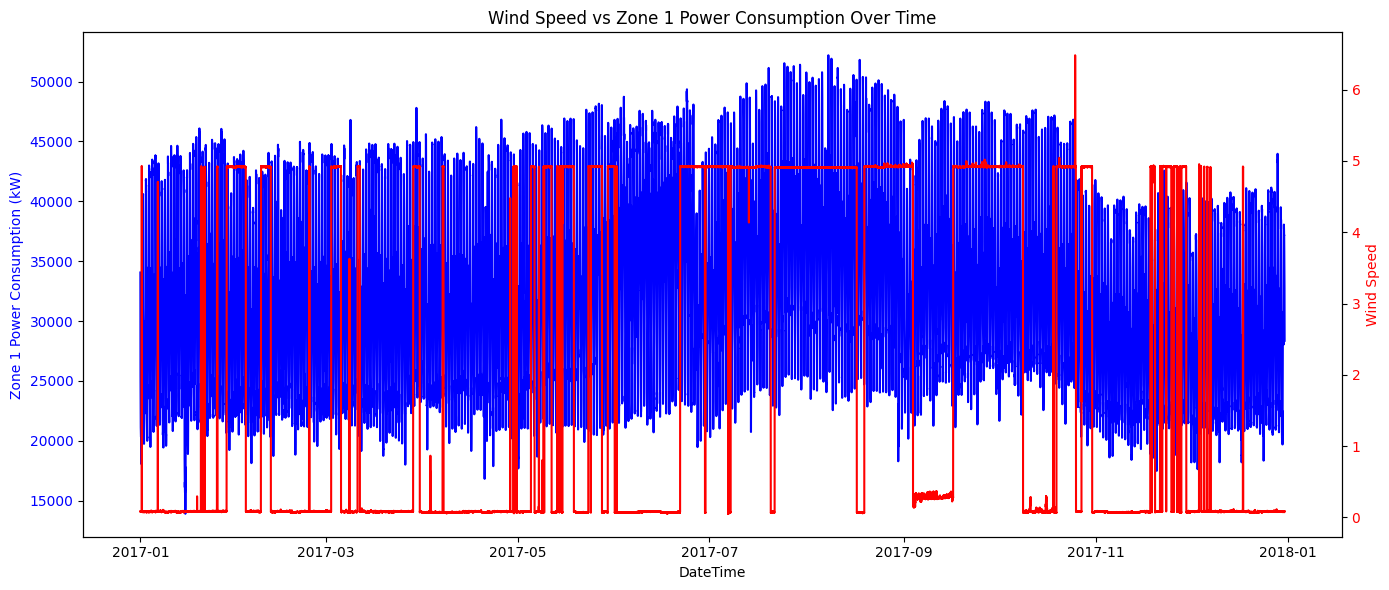

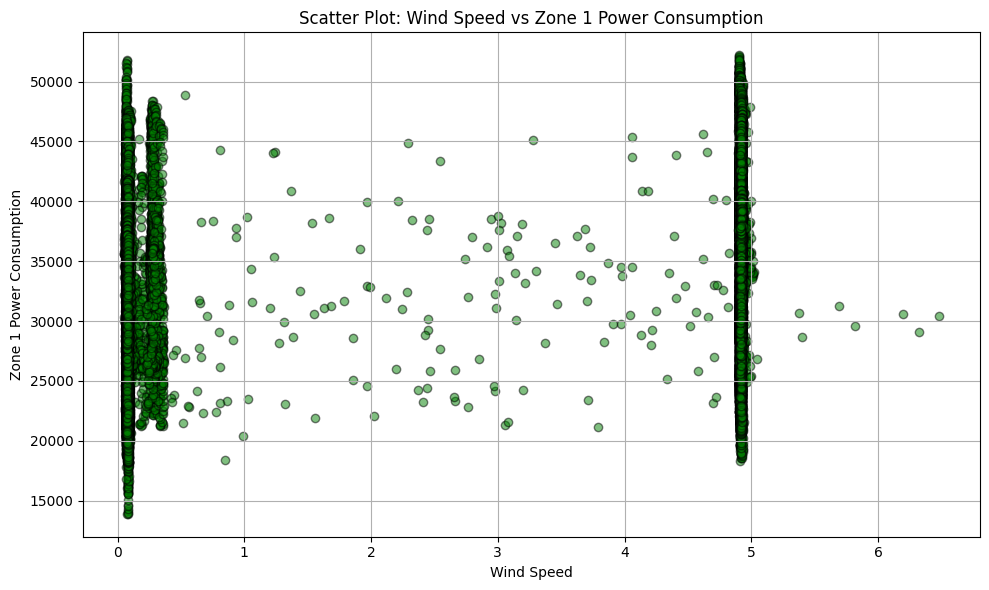

diffuse flows: min = 0.011, max = 936.0
Zone 1 Power Consumption: min = 13895.6962, max = 52204.39512


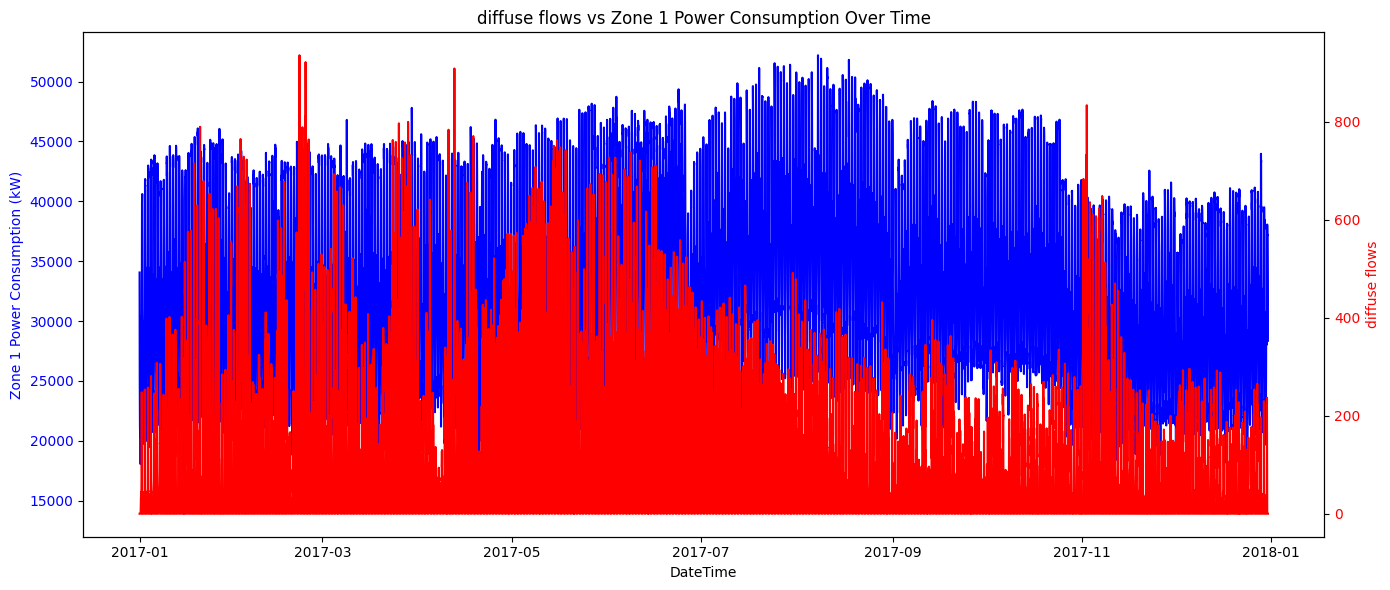

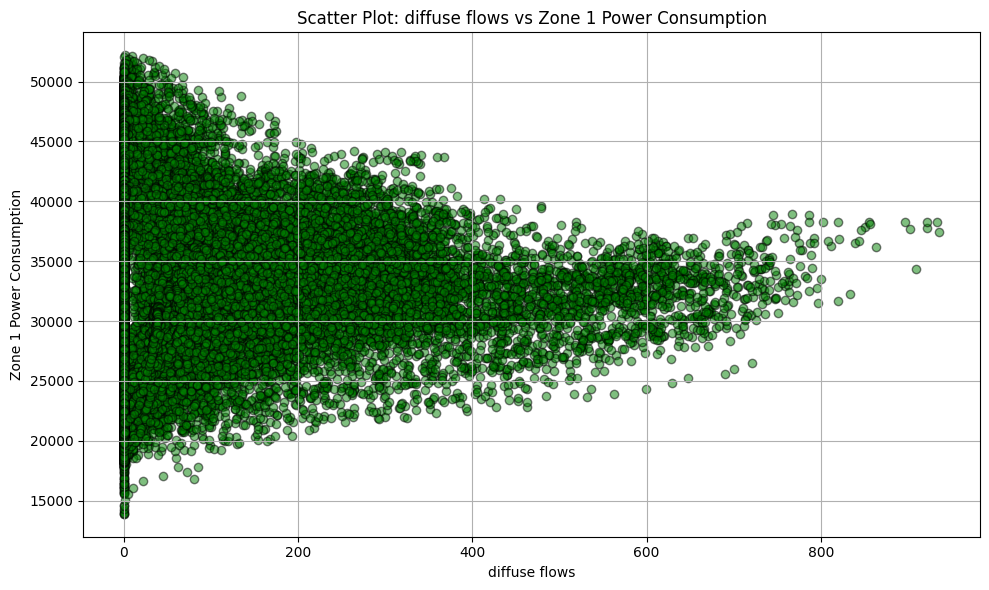

general diffuse flows: min = 0.004, max = 1163.0
Zone 1 Power Consumption: min = 13895.6962, max = 52204.39512


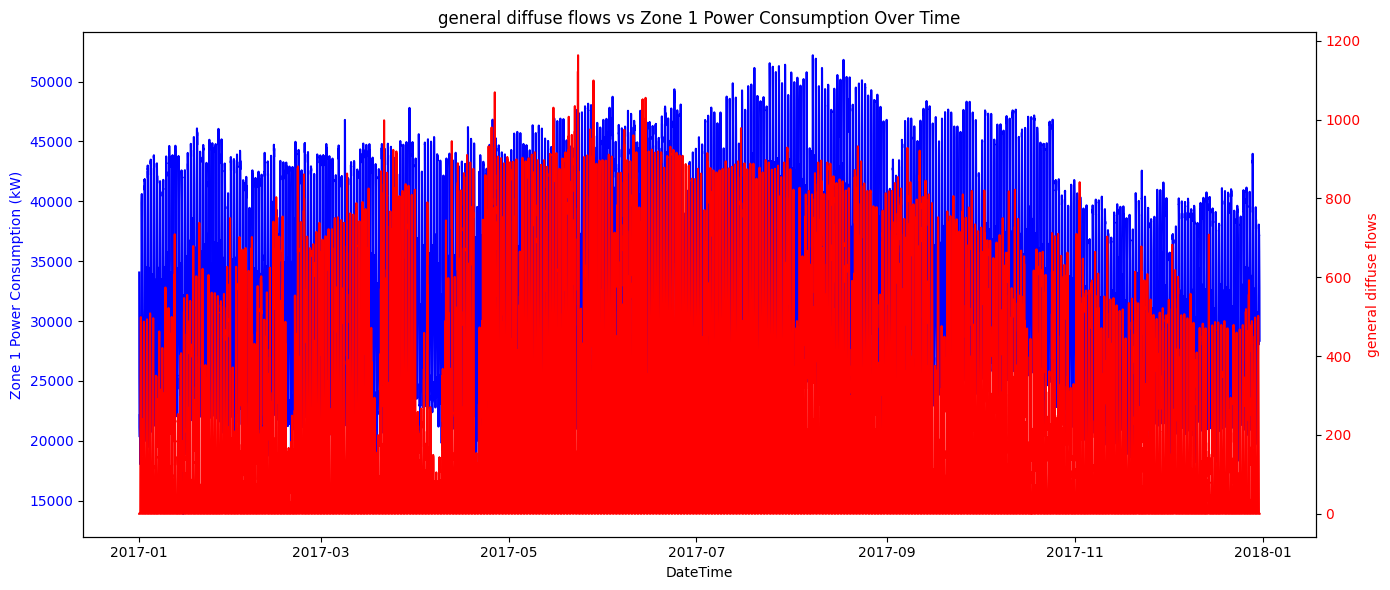

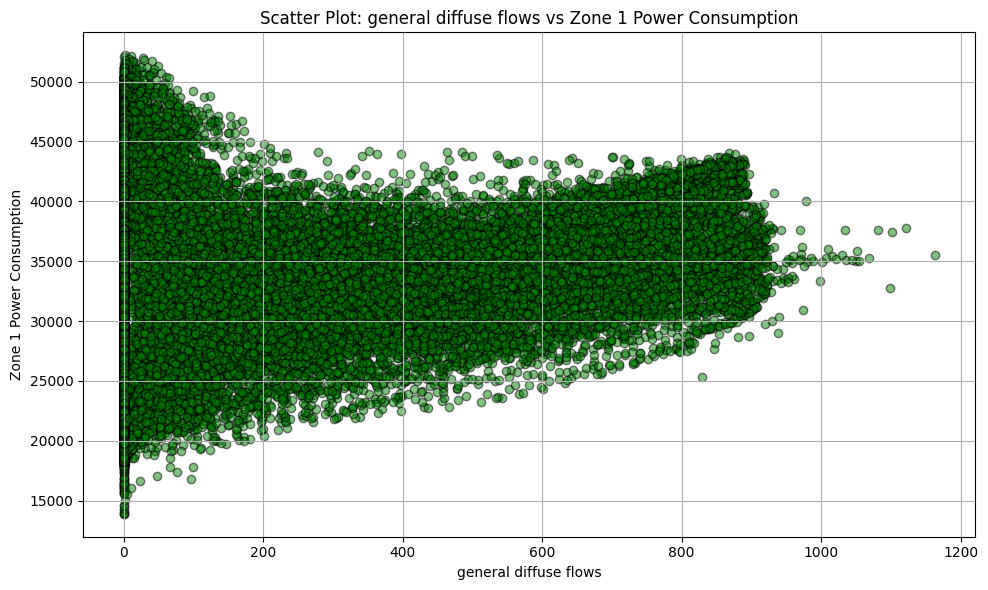

In [6]:
# List of environmental features to analyze
features = ['Temperature', 'Humidity', 'Wind Speed', 'diffuse flows', 'general diffuse flows']

for feature in features:
    print(f"{feature}: min = {dataset[feature].min()}, max = {dataset[feature].max()}")
    print(f"Zone 1 Power Consumption: min = {dataset['Zone 1 Power Consumption'].min()}, max = {dataset['Zone 1 Power Consumption'].max()}")

    # --- LINE PLOT: Over Time ---
    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.plot(dataset.index, dataset['Zone 1 Power Consumption'], color='blue', label='Zone 1 Power Consumption')
    ax1.set_xlabel('DateTime')
    ax1.set_ylabel('Zone 1 Power Consumption (kW)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(dataset.index, dataset[feature], color='red', label=feature)
    ax2.set_ylabel(f'{feature}', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'{feature} vs Zone 1 Power Consumption Over Time')
    fig.tight_layout()
    plt.show()

    # --- SCATTER PLOT: Feature vs Power Consumption ---
    plt.figure(figsize=(10, 6))
    plt.scatter(dataset[feature], dataset['Zone 1 Power Consumption'],
                alpha=0.5, c='green', edgecolors='k')

    plt.title(f'Scatter Plot: {feature} vs Zone 1 Power Consumption')
    plt.xlabel(feature)
    plt.ylabel('Zone 1 Power Consumption')
    plt.grid(True)
    plt.tight_layout()
    plt.show()




**Observations and Analysis**
- Temperature (Min: 3.25°C, Max: 40.01°C):
  - Correlation (0.44): moderate positive correlation
  - Summer: As temperature increases - power consumption increases (especially in summer)
  - Winter: low temperatue - moderate heating use, less intence than cooling in hotter months
  - Power consumption peaks in hotter months

- Humidity (Min: 11.34%, Max: 94.8%)
  - Correlation: Low to moderate
  - High humidity makes air feel warmer, which can amplify cooling demand
  - however humidity alone stringly does not drive power consumption, unless paired with temperature
  - has indirect effect: its correlation with temperature and comfort affects behaviour

- Wind speed (Min: 0.05, Max: 6.48 m/s)
  - Correlation: weak
  - wind may help reduce indoor temperature passively
  - But in cities - wind has minimal direct impact

- Solar radiation
  - Diffuse Flows (Min: 0.01, Max: 936.0 Watts per square meter): Indirect solar radiation scattered by clouds, dust, etc.
  - General Diffuse Flows (Min: 0.004, Max: 1163.0 Watts per square meter): May include both direct and indirect components or be a broader measurement.
    - Above both DIffuse Flows & General Diffuse Flows represent solar radiation
    - Higher solar radiation → hotter days → more cooling demand → higher power consumption.
    - Moderate correlation with power use due to this indirect relationship.
    - Useful as predictive features for power forecasting.

  
**Overall interpretation**
  - Temperature is the strongest driver of power consumption, especially during peak summer.
  - Humidity amplifies discomfort, especially when combined with high temperatures.
  - Wind Speed can act as a natural moderator, occasionally reducing cooling load.
  - Diffuse and General Diffuse Flows silently contribute to heating of indoor environments, even on non-sunny days.
  - Power usage patterns mirror human activity cycles, but the magnitude is heavily modulated by environmental features.

**what the scatter plot shows**
- Each dot represents a 10 minute record
- It helps identify trend or pattern - whether power consumtion increases with temperature

#### Zone 2 Power Consumption vs Environmental Features

Temperature: min = 3.247, max = 40.01
Zone 2 Power Consumption: min = 8560.081466, max = 37408.86076


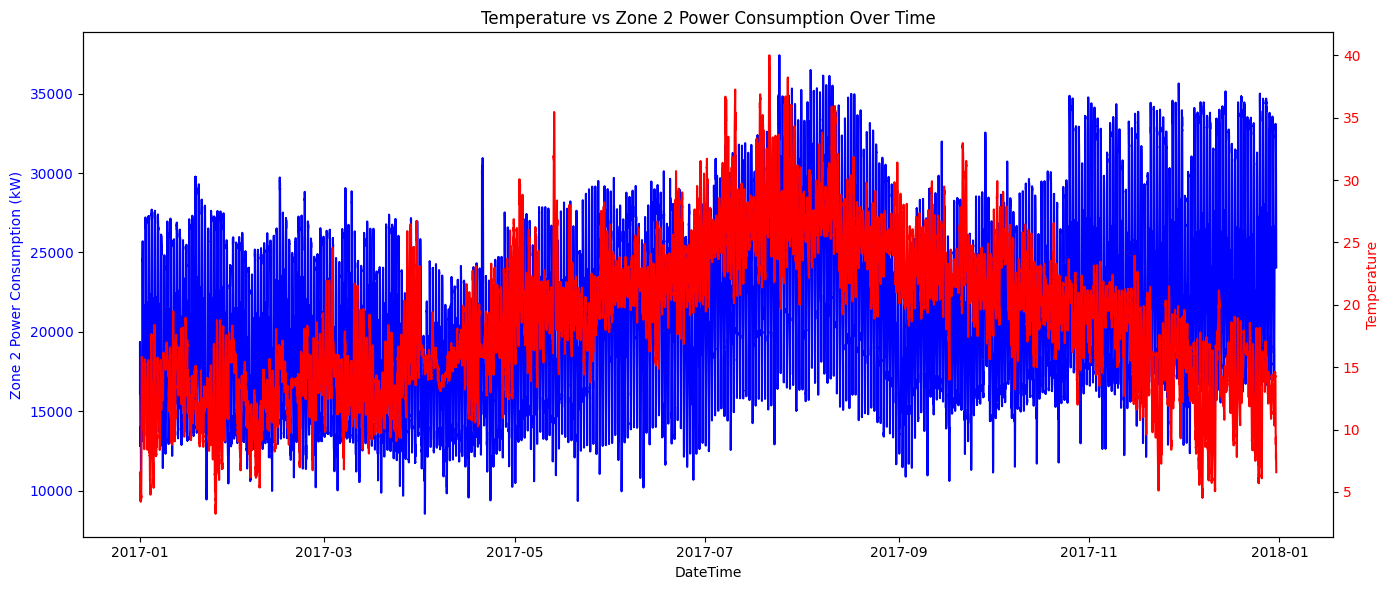

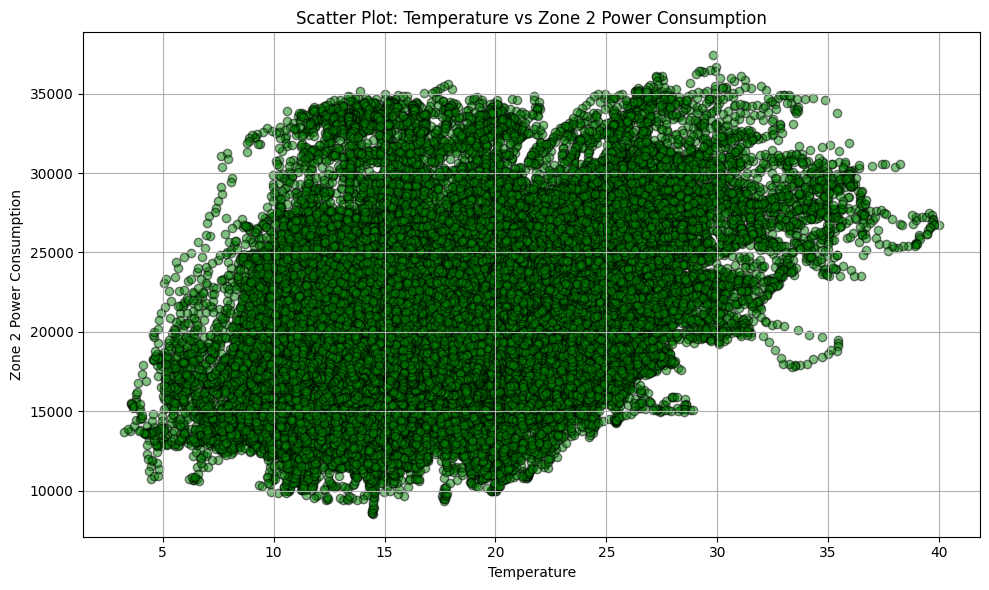

Humidity: min = 11.34, max = 94.8
Zone 2 Power Consumption: min = 8560.081466, max = 37408.86076


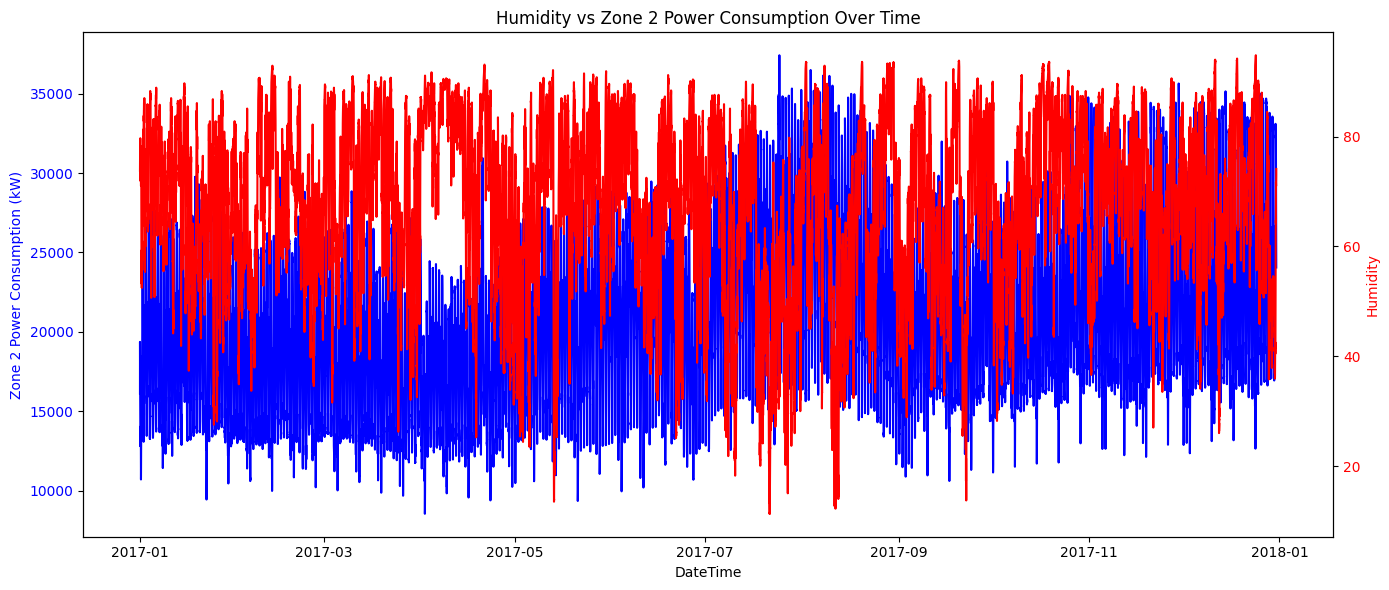

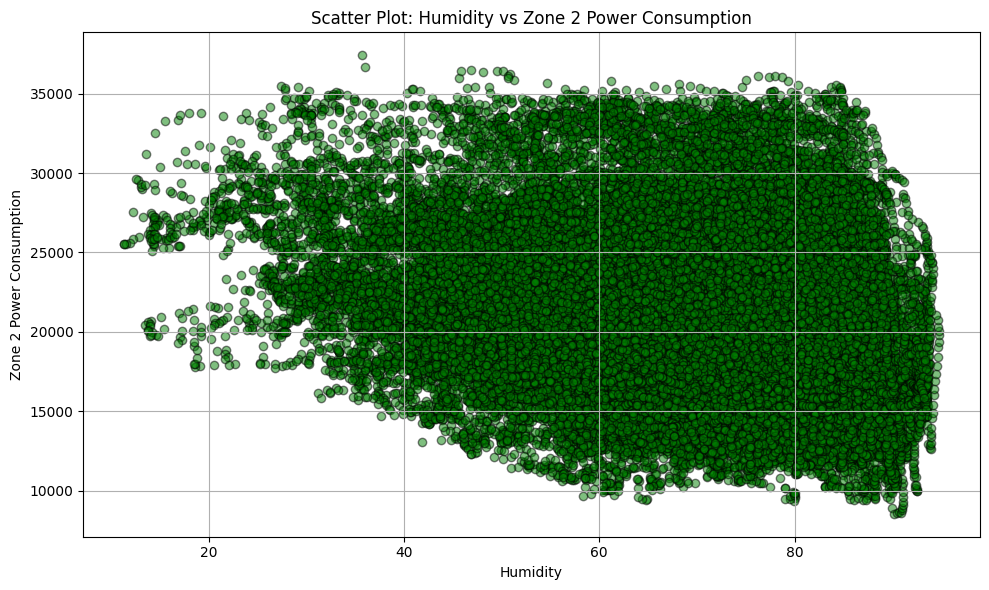

Wind Speed: min = 0.05, max = 6.483
Zone 2 Power Consumption: min = 8560.081466, max = 37408.86076


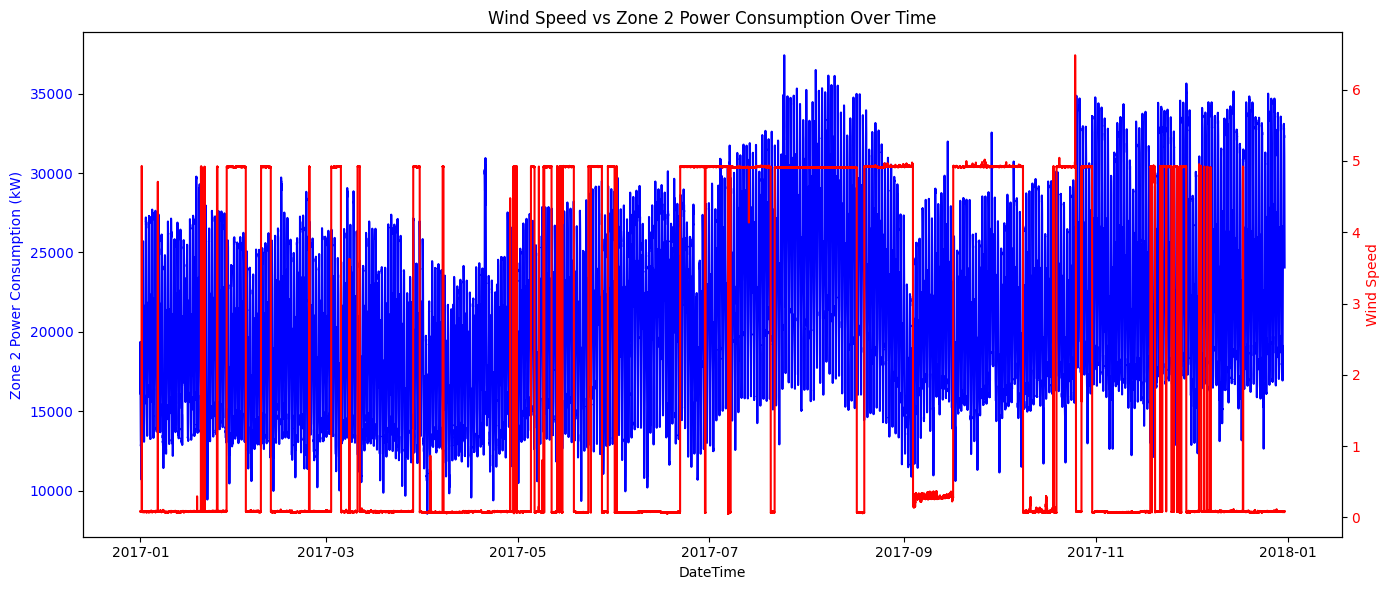

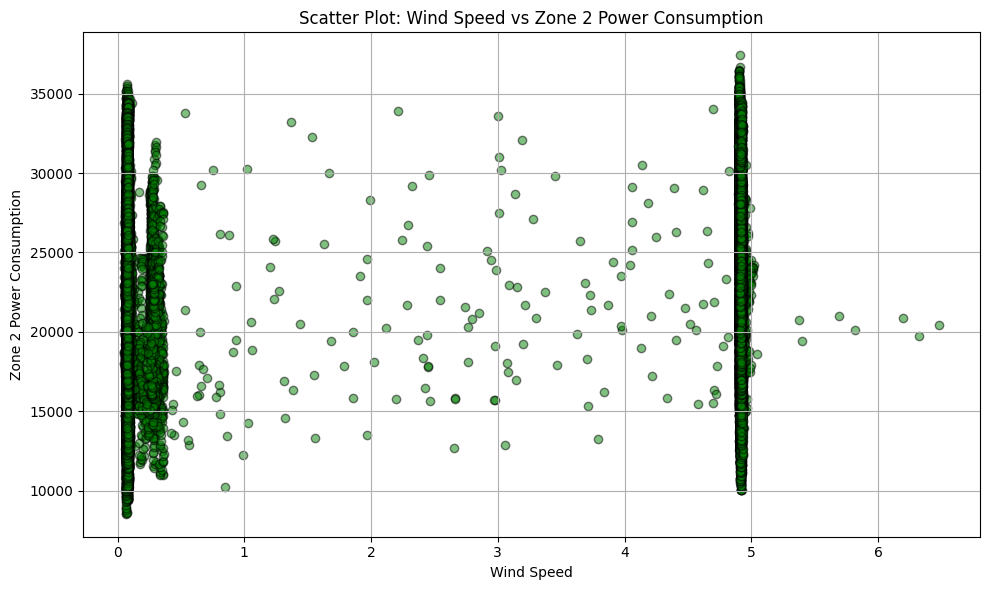

diffuse flows: min = 0.011, max = 936.0
Zone 2 Power Consumption: min = 8560.081466, max = 37408.86076


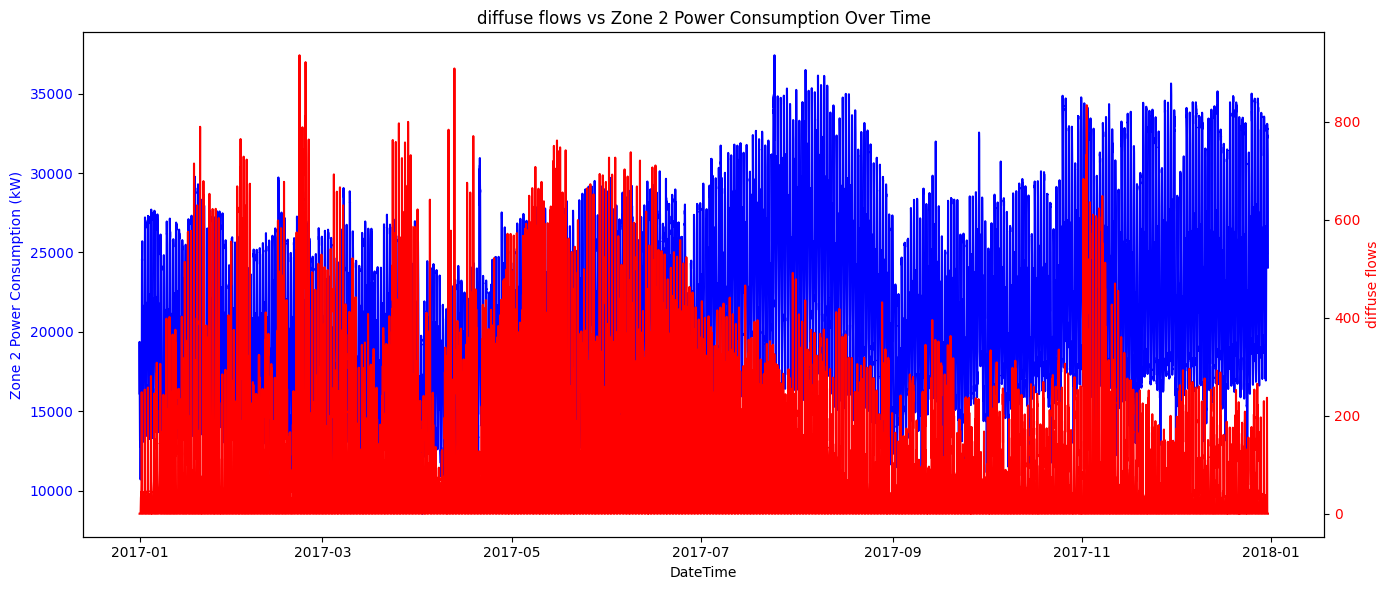

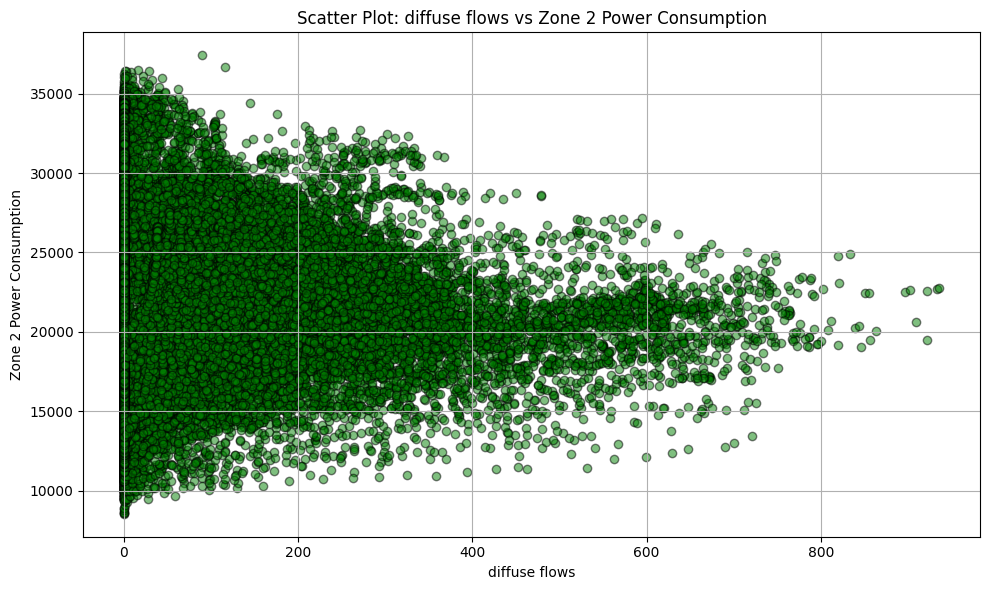

general diffuse flows: min = 0.004, max = 1163.0
Zone 2 Power Consumption: min = 8560.081466, max = 37408.86076


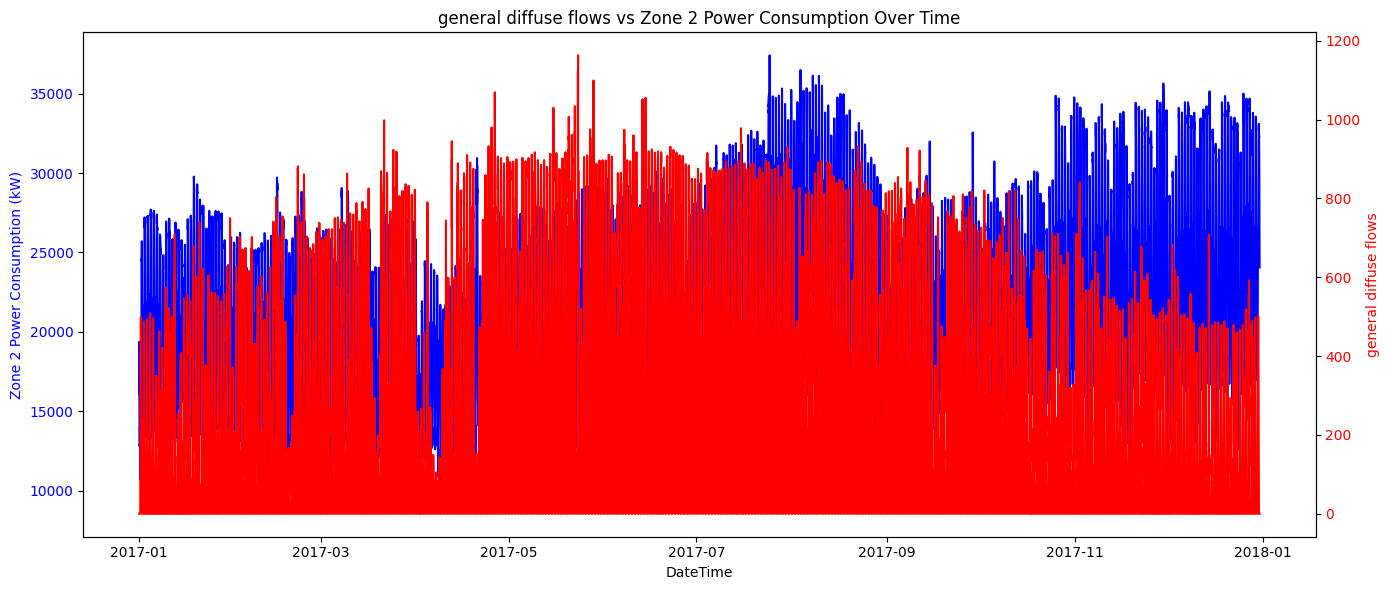

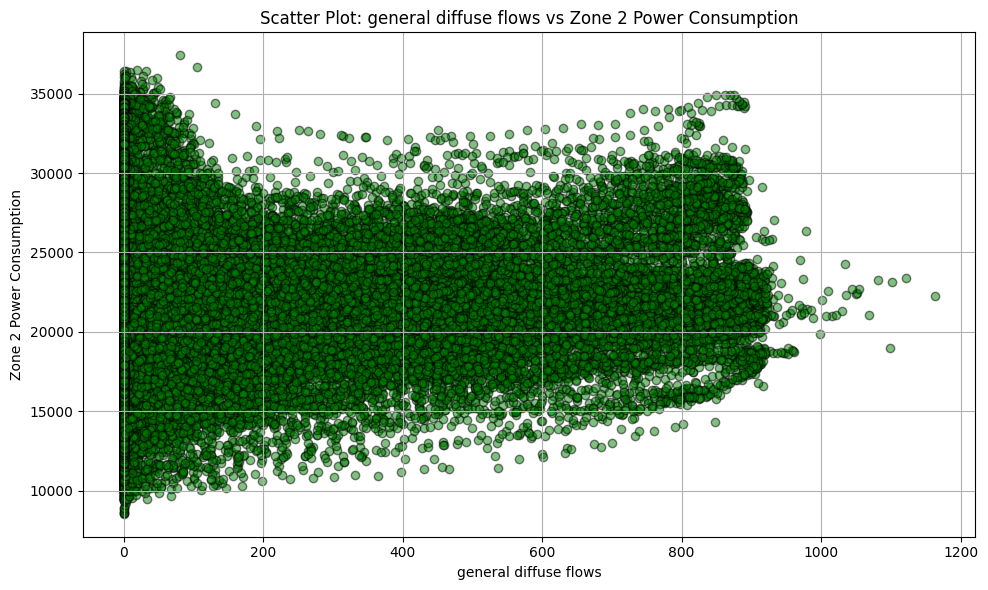

In [7]:
# List of environmental features to analyze
features = ['Temperature', 'Humidity', 'Wind Speed', 'diffuse flows', 'general diffuse flows']

for feature in features:
    print(f"{feature}: min = {dataset[feature].min()}, max = {dataset[feature].max()}")
    print(f"Zone 2 Power Consumption: min = {dataset['Zone 2 Power Consumption'].min()}, max = {dataset['Zone 2 Power Consumption'].max()}")

    # --- LINE PLOT: Over Time ---
    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.plot(dataset.index, dataset['Zone 2 Power Consumption'], color='blue', label='Zone 2 Power Consumption')
    ax1.set_xlabel('DateTime')
    ax1.set_ylabel('Zone 2 Power Consumption (kW)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(dataset.index, dataset[feature], color='red', label=feature)
    ax2.set_ylabel(f'{feature}', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'{feature} vs Zone 2 Power Consumption Over Time')
    fig.tight_layout()
    plt.show()

    # --- SCATTER PLOT: Feature vs Power Consumption ---
    plt.figure(figsize=(10, 6))
    plt.scatter(dataset[feature], dataset['Zone 2 Power Consumption'],
                alpha=0.5, c='green', edgecolors='k')

    plt.title(f'Scatter Plot: {feature} vs Zone 2 Power Consumption')
    plt.xlabel(feature)
    plt.ylabel('Zone 2 Power Consumption')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

- Zone 2 shows similar environmental sensitivity as Zone 1, just with slightly lower usage peaks.
- Temperature + Humidity combo drives most power consumption.
- Solar radiation (diffuse flows), while less obvious, still plays a silent but steady role.

#### Zone 3 Power Consumption vs Environmental Features

Temperature: min = 3.247, max = 40.01
Zone 3 Power Consumption: min = 5935.17407, max = 47598.32636


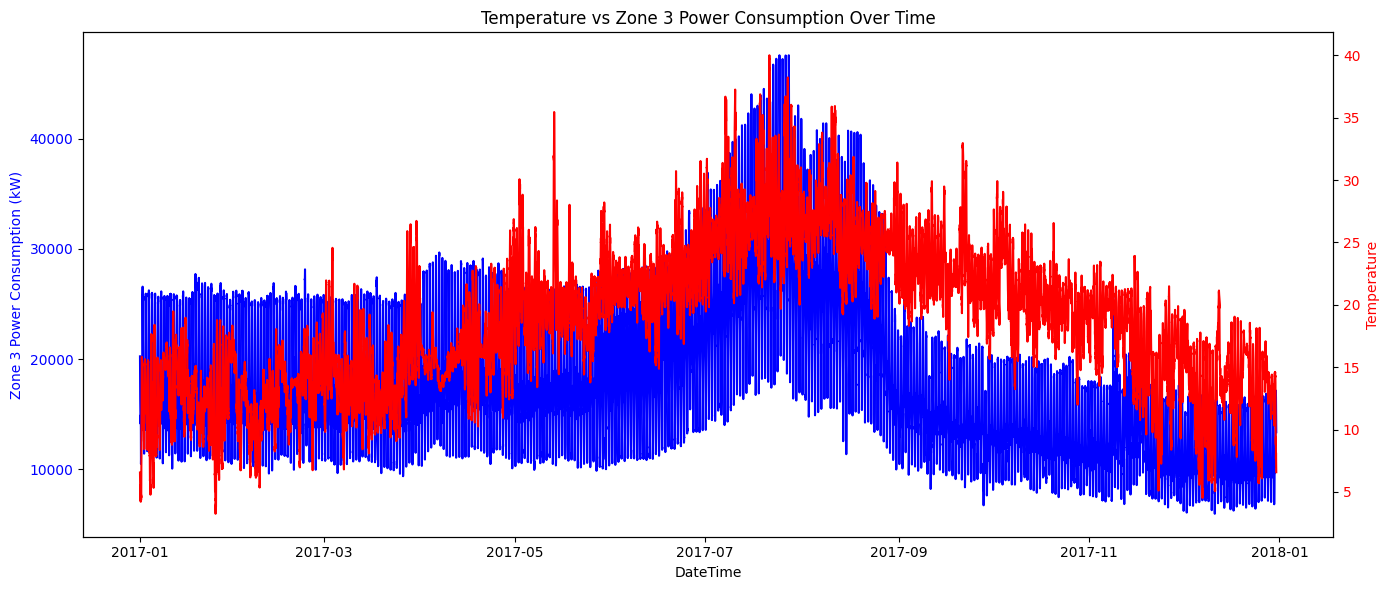

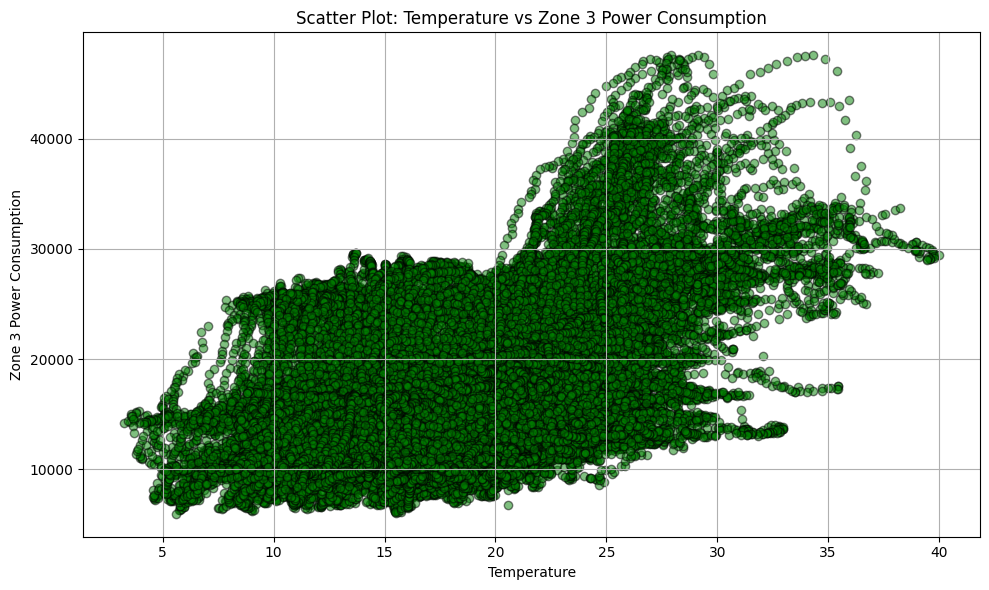

Humidity: min = 11.34, max = 94.8
Zone 3 Power Consumption: min = 5935.17407, max = 47598.32636


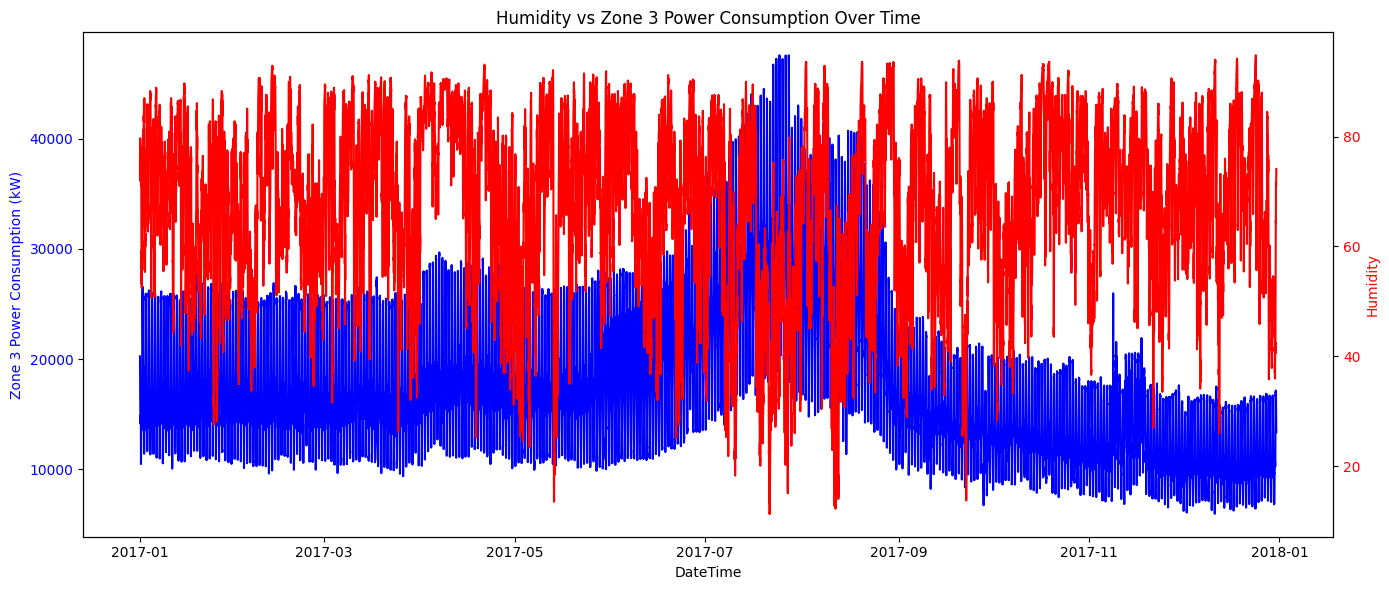

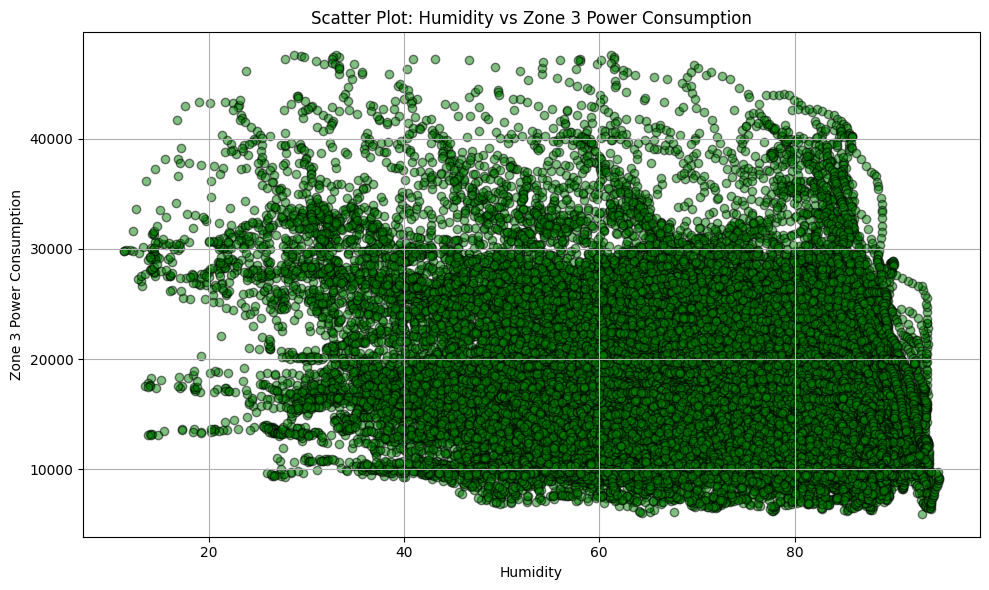

Wind Speed: min = 0.05, max = 6.483
Zone 3 Power Consumption: min = 5935.17407, max = 47598.32636


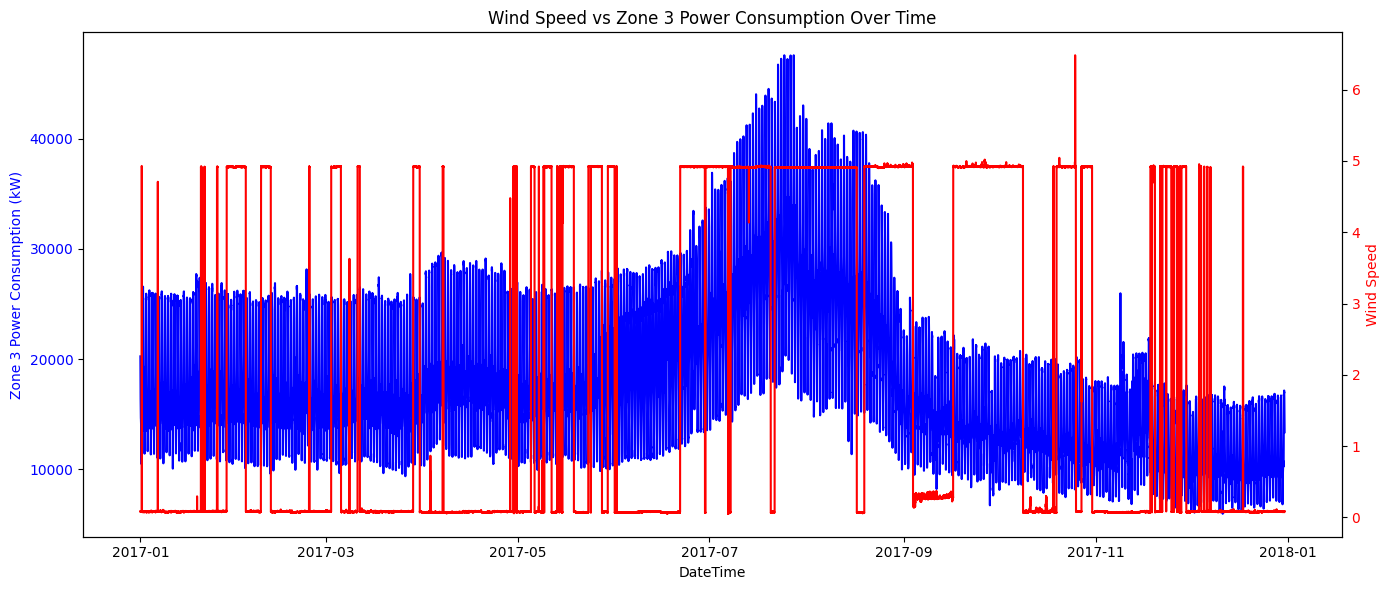

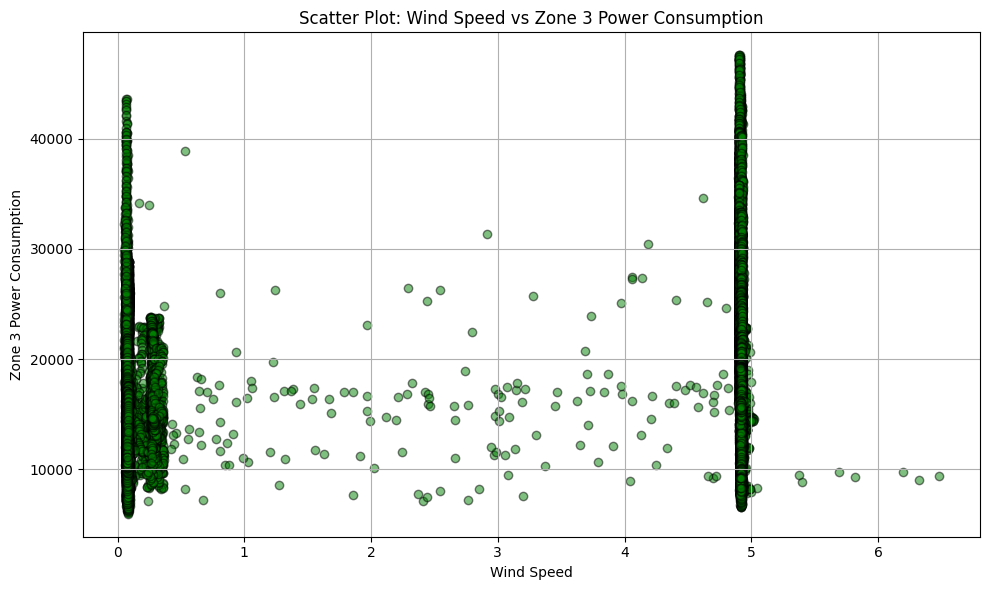

diffuse flows: min = 0.011, max = 936.0
Zone 3 Power Consumption: min = 5935.17407, max = 47598.32636


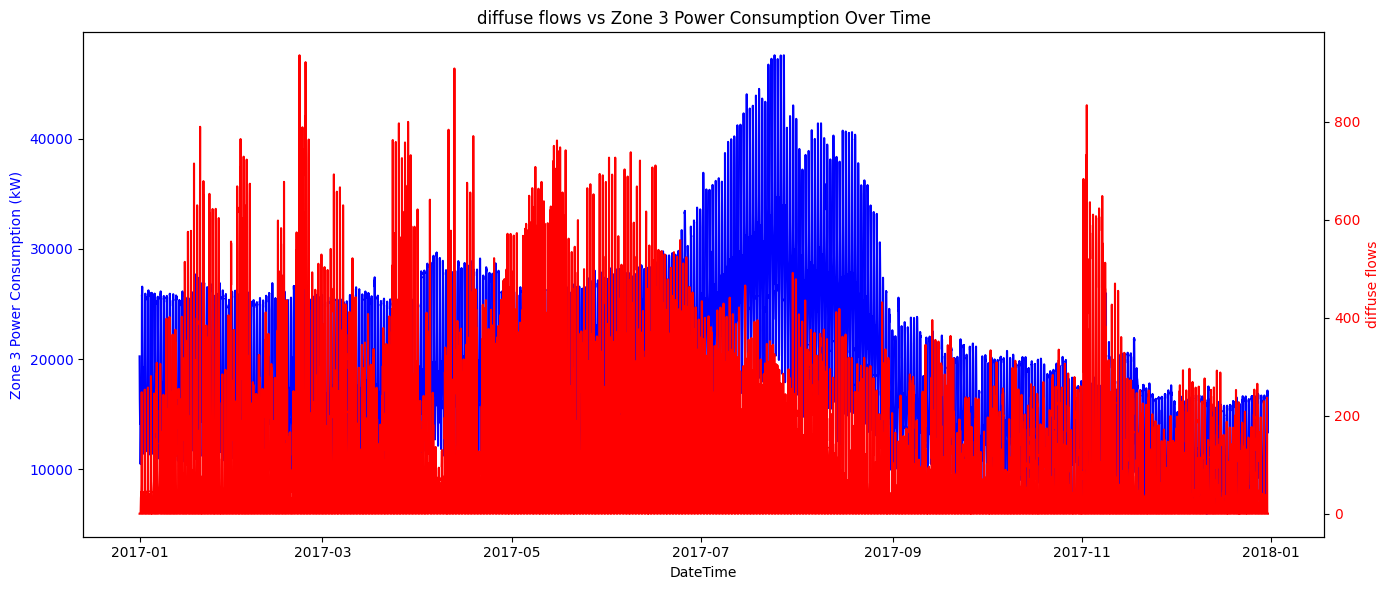

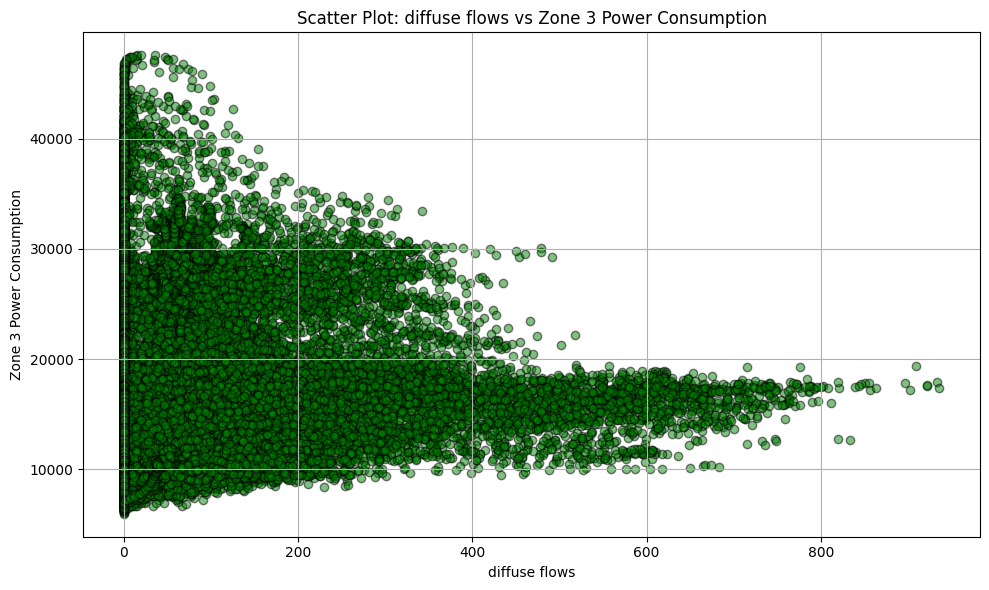

general diffuse flows: min = 0.004, max = 1163.0
Zone 3 Power Consumption: min = 5935.17407, max = 47598.32636


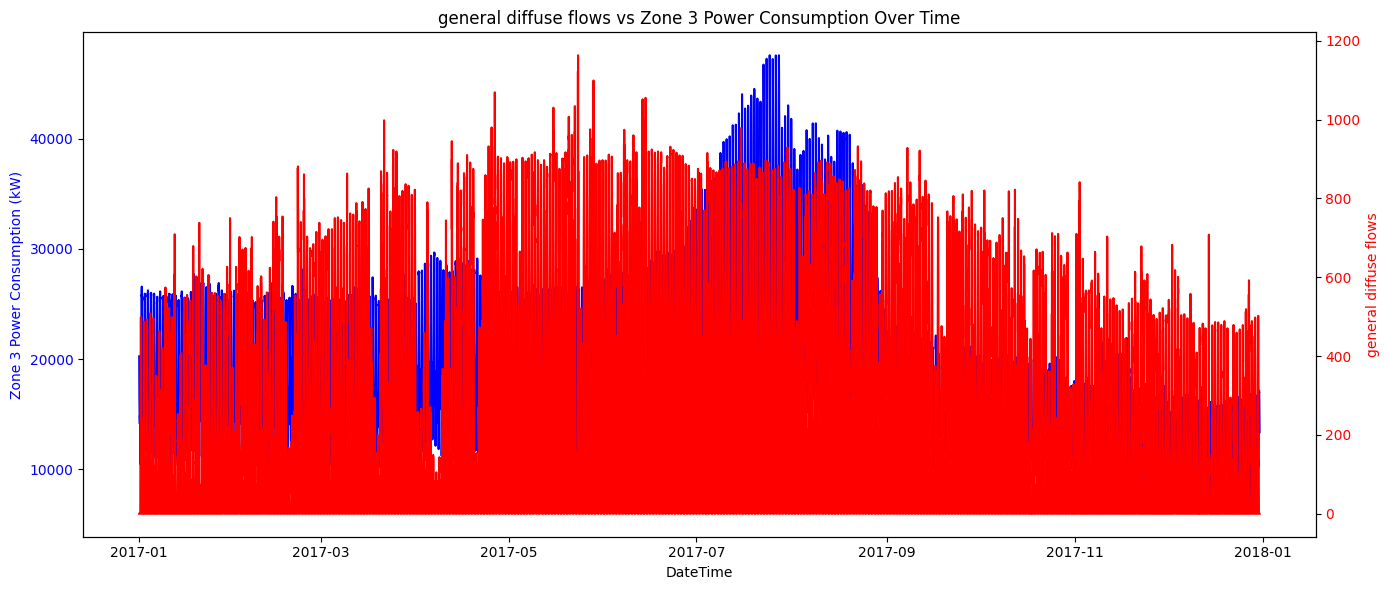

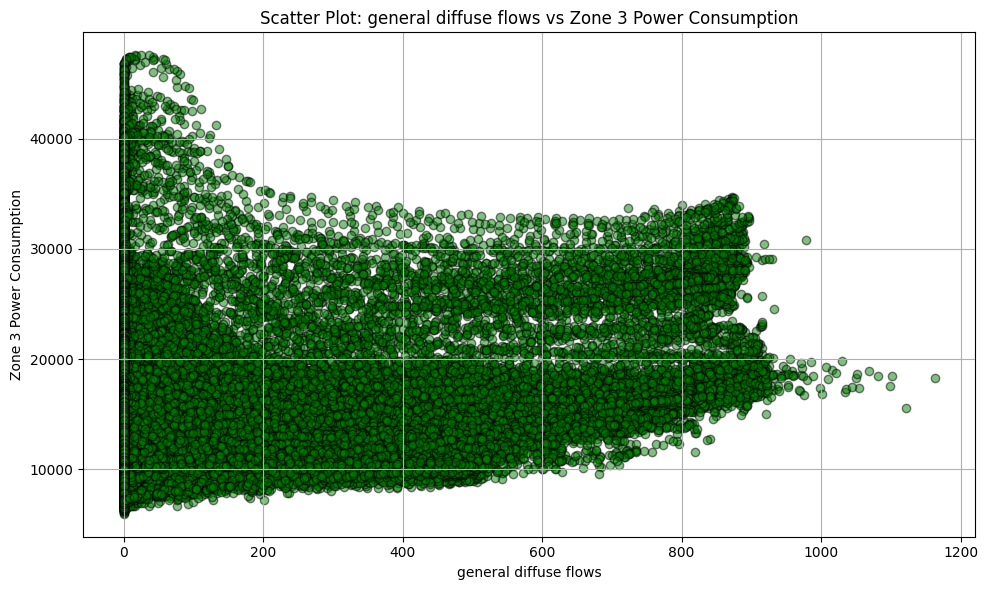

In [8]:
# List of environmental features to analyze
features = ['Temperature', 'Humidity', 'Wind Speed', 'diffuse flows', 'general diffuse flows']

for feature in features:
    print(f"{feature}: min = {dataset[feature].min()}, max = {dataset[feature].max()}")
    print(f"Zone 3 Power Consumption: min = {dataset['Zone 3 Power Consumption'].min()}, max = {dataset['Zone 3 Power Consumption'].max()}")

    # --- LINE PLOT: Over Time ---
    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.plot(dataset.index, dataset['Zone 3 Power Consumption'], color='blue', label='Zone 3 Power Consumption')
    ax1.set_xlabel('DateTime')
    ax1.set_ylabel('Zone 3 Power Consumption (kW)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(dataset.index, dataset[feature], color='red', label=feature)
    ax2.set_ylabel(f'{feature}', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'{feature} vs Zone 3 Power Consumption Over Time')
    fig.tight_layout()
    plt.show()

    # --- SCATTER PLOT: Feature vs Power Consumption ---
    plt.figure(figsize=(10, 6))
    plt.scatter(dataset[feature], dataset['Zone 3 Power Consumption'],
                alpha=0.5, c='green', edgecolors='k')

    plt.title(f'Scatter Plot: {feature} vs Zone 3 Power Consumption')
    plt.xlabel(feature)
    plt.ylabel('Zone 3 Power Consumption')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

- Zone 3 is power-intensive, second only to Zone 1 in peak usage.
- Its sensitivity to environmental conditions mirrors Zone 1 more than Zone 2.
- Particularly visible in response to solar radiation (diffuse flows).
- Humidity and temperature together drive major increases in consumption — especially during afternoons and early evenings.
- Power usage is closely aligned with daily human activity, but environmental modulation (via temperature, solar gain, and humidity) shapes the magnitude of usage.

### Correlation matrix for all environmental features and power consumption zones

In [9]:
# Compute correlation matrix for all environmental features and power consumption zones
correlation = dataset[[
    'Temperature', 'Humidity', 'Wind Speed', 'diffuse flows', 'general diffuse flows',
    'Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption'
]].corr()

# Display the correlation matrix
print(correlation)

                          Temperature  Humidity  Wind Speed  diffuse flows  \
Temperature                  1.000000 -0.460243    0.477109       0.196522   
Humidity                    -0.460243  1.000000   -0.135853      -0.256886   
Wind Speed                   0.477109 -0.135853    1.000000      -0.000972   
diffuse flows                0.196522 -0.256886   -0.000972       1.000000   
general diffuse flows        0.460294 -0.468138    0.133733       0.564718   
Zone 1 Power Consumption     0.440221 -0.287421    0.167444       0.080274   
Zone 2 Power Consumption     0.382428 -0.294961    0.146413       0.044667   
Zone 3 Power Consumption     0.489527 -0.233022    0.278641      -0.038506   

                          general diffuse flows  Zone 1 Power Consumption  \
Temperature                            0.460294                  0.440221   
Humidity                              -0.468138                 -0.287421   
Wind Speed                             0.133733                  0

**Correlation Data**

| **Feature**               | **Zone 1** | **Zone 2** | **Zone 3** |
| ------------------------- | ---------- | ---------- | ---------- |
| **Temperature**           | 0.440      | 0.382      | 0.490      |
| **Humidity**              | -0.287     | -0.295     | -0.233     |
| **Wind Speed**            | 0.167      | 0.146      | 0.279      |
| **Diffuse Flows**         | 0.080      | 0.045      | -0.039     |
| **General Diffuse Flows** | 0.188      | 0.157      | 0.063      |


### Daily and weekly power consumption pattern acros zones

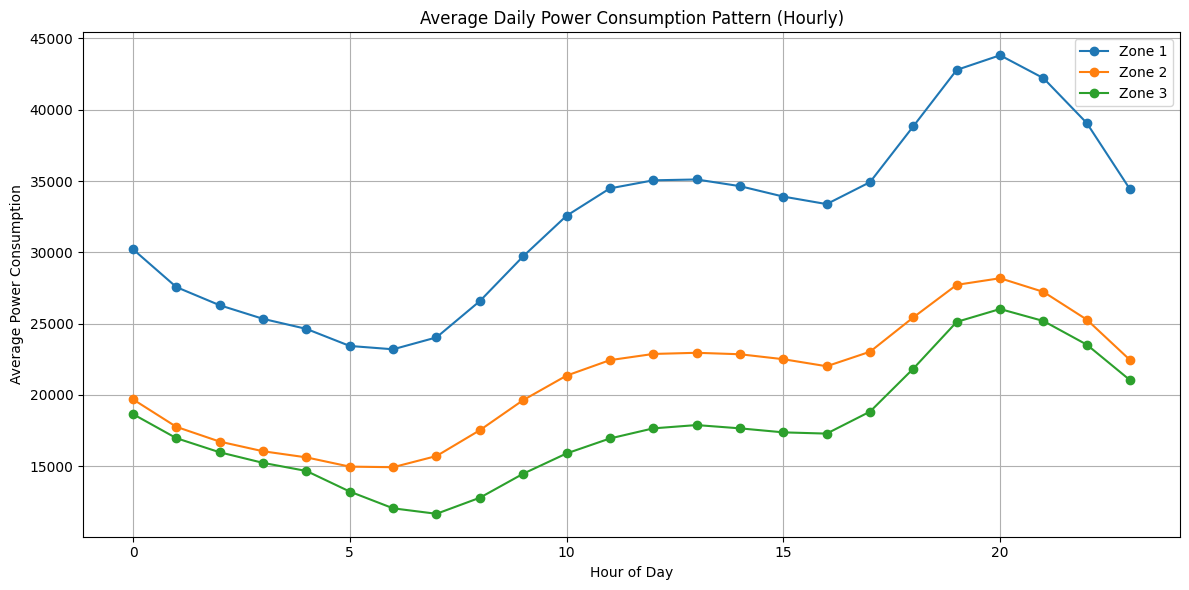

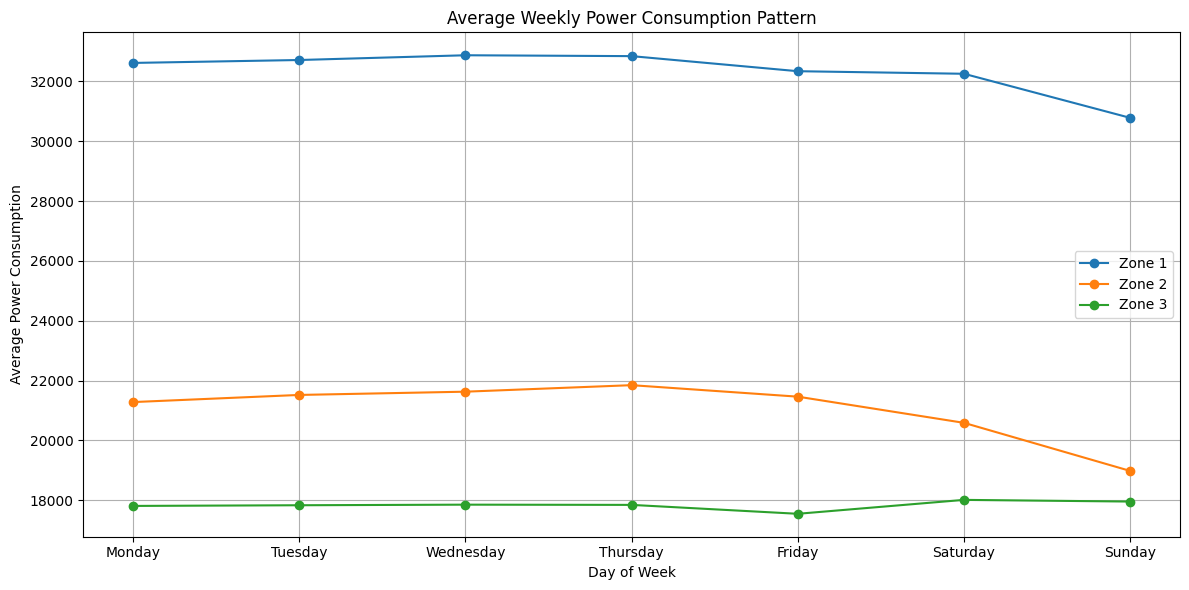

In [10]:
# Create new columns for time and weekday
dataset['Hour'] = dataset.index.hour
dataset['Weekday'] = dataset.index.day_name()

# Average hourly pattern (daily cycle)
hourly_avg = dataset.groupby('Hour')[
    ['Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption']
].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg, marker='o')
plt.title('Average Daily Power Consumption Pattern (Hourly)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power Consumption')
plt.legend(['Zone 1', 'Zone 2', 'Zone 3'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Average weekday pattern
weekday_avg = dataset.groupby('Weekday')[
    ['Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption']
].mean()

# Reorder weekdays for plot
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_avg = weekday_avg.reindex(weekday_order)

plt.figure(figsize=(12, 6))
plt.plot(weekday_avg, marker='o')
plt.title('Average Weekly Power Consumption Pattern')
plt.xlabel('Day of Week')
plt.ylabel('Average Power Consumption')
plt.legend(['Zone 1', 'Zone 2', 'Zone 3'])
plt.grid(True)
plt.tight_layout()
plt.show()


### Seasonal and Time of day patterns

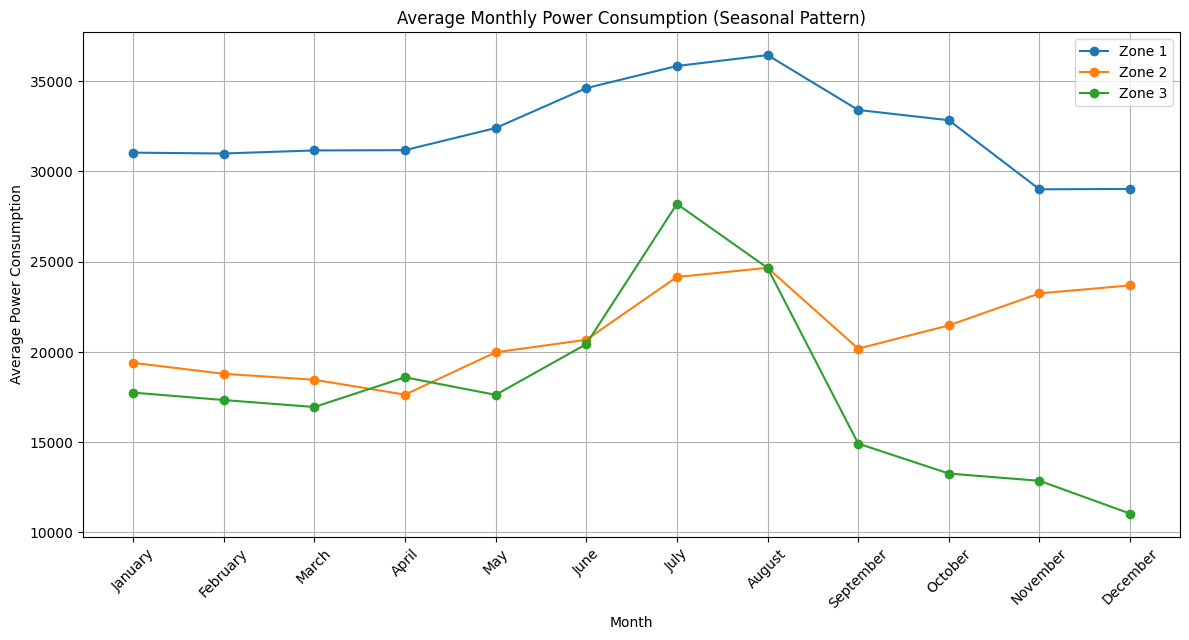

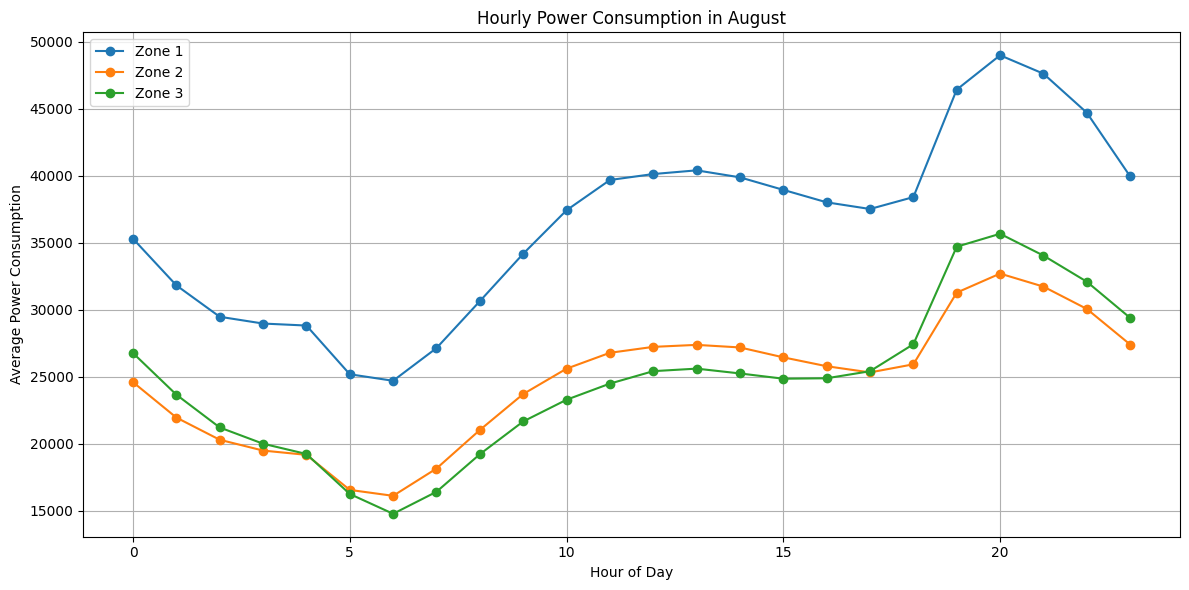

In [11]:
dataset['Month'] = dataset.index.month_name()

# Average monthly consumption
monthly_avg = dataset.groupby('Month')[
    ['Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption']
].mean()

# Order months correctly
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_avg = monthly_avg.reindex(month_order)

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg, marker='o')
plt.title('Average Monthly Power Consumption (Seasonal Pattern)')
plt.xlabel('Month')
plt.ylabel('Average Power Consumption')
plt.legend(['Zone 1', 'Zone 2', 'Zone 3'])
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Time-of-day usage for a selected month (e.g., August)
selected_month = 'August'
august_data = dataset[dataset['Month'] == selected_month]

august_hourly_avg = august_data.groupby('Hour')[
    ['Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption']
].mean()

plt.figure(figsize=(12, 6))
plt.plot(august_hourly_avg, marker='o')
plt.title(f'Hourly Power Consumption in {selected_month}')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power Consumption')
plt.legend(['Zone 1', 'Zone 2', 'Zone 3'])
plt.grid(True)
plt.tight_layout()
plt.show()

### Heatmap for correlation data

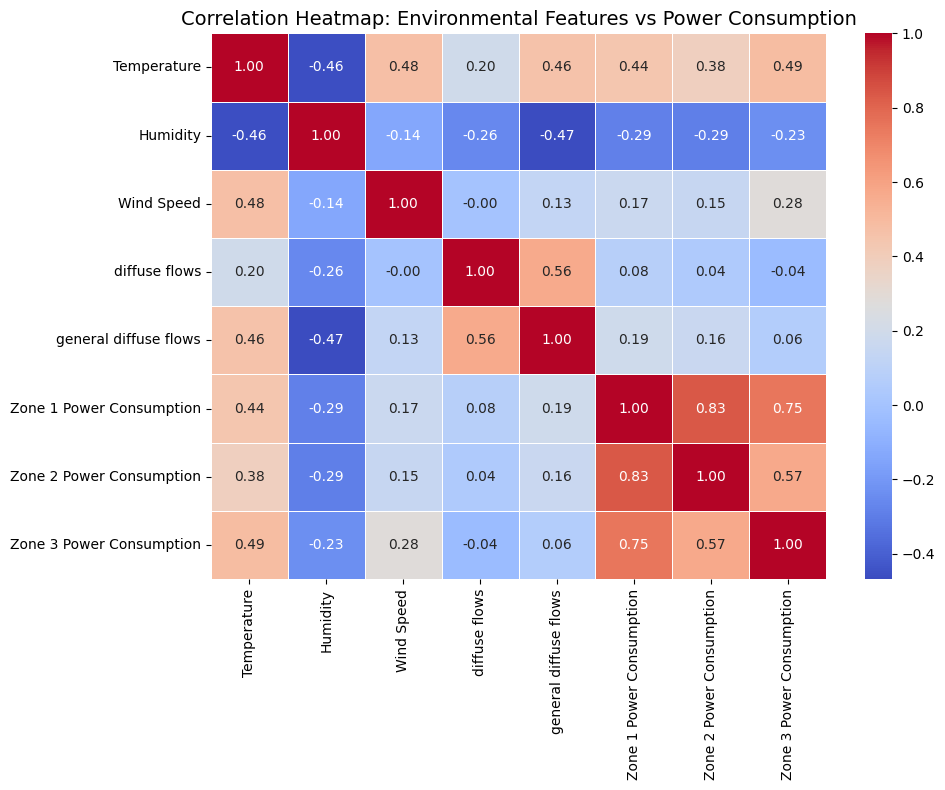

In [12]:
plt.figure(figsize=(10, 8))  # Adjust size as needed
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Environmental Features vs Power Consumption', fontsize=14)
plt.tight_layout()
plt.show()

- Heatmap showing correlation between environmental features and power consumption across Zone 1, 2 & 3
  - Temperature has the strongest positive correlation with the power consumption in all zones
  - Humidity is moderatively negatively correlated across all zones
  - WInd speed has mild positive correlation acorss all zones, more noticeable for Zone 3
  - General Diffuse and Diffuse flows show weak correlation - with slightly positive values in zone 1 & 2

## Analyze lag effects

### Lag Analysis for each zone

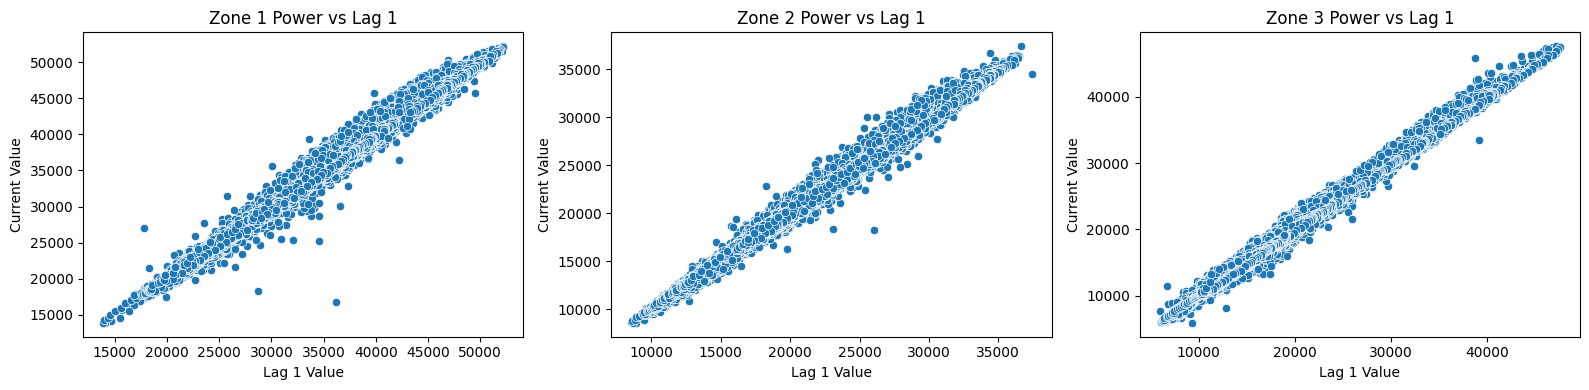

In [13]:
# Create lag columns for each zone
dataset['Zone1PowerConsumption_lag1'] = dataset['Zone 1 Power Consumption'].shift(1)
dataset['Zone2PowerConsumption_lag1'] = dataset['Zone 2 Power Consumption'].shift(1)
dataset['Zone3PowerConsumption_lag1'] = dataset['Zone 3 Power Consumption'].shift(1)

# Plot lag relationships
zones = ['Zone 1', 'Zone 2', 'Zone 3']

plt.figure(figsize=(16, 4))

for i, zone in enumerate(zones):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(
        x=dataset[f'{zone} Power Consumption'.replace(' ', '') + '_lag1'],
        y=dataset[f'{zone} Power Consumption']
    )
    plt.title(f'{zone} Power vs Lag 1')
    plt.xlabel('Lag 1 Value')
    plt.ylabel('Current Value')

plt.tight_layout()
plt.show()


- the scatter plot shows points closely aligned along the diagonal line
  - Zone 1 & Zone 2 showing almost similar plot with points slightly scattered
  - Zone 3 shows points very closely aligned along the diagonal line

  
- There is a strong autocorrelation (i.e: current power usage is similar to the previous one)

## Insights

1. **Strong AutoCorrelation (Lag-1) insight**
  - All three zones exhibit strong autocorrelation, especially Zone 3, as shown by how closely the points align along the diagonal line.
    - This indicates that previous power consumption is a strong predictor of current power consumption.

  - Zone 1 and Zone 2 also follow this pattern, though with slightly more scatter — possibly due to more influence from external/environmental variables or human activity variability.
  

2. **Environmental correlation Insights**
  - Temperature
    - Positively correlated across all zones
    - Key driver of power usage, especially in summer months
  
  - Humidity
    - Moderately negatively correlated across all zones
    - Correlation is inverse possibly due to inverse seasonal trends (e.g: high humidity in cooler months)
  
  - Wind speed
    - Weak to moderate positive correlation, strongest with Zone 3
    - Moderate effect

  - Diffuse & General Diffuse Flows
    - Weak correlations overall
    - General Diffuse flows are slightly more correlated with Zone 1 - suggesting minor influence from indirect solar radiation


3. **Inter Zone relationship**
  - Zone 1 and Zone 2: High inter-correlation (~0.83), indicating similar load profiles — likely due to similar usage types or shared building infrastructure.
  - Zone 3 also shows strong correlation with the others (Zone 1: 0.75, Zone 2: 0.57), but slightly more independent — possibly due to different occupancy or use patterns.